### Social Media Analysis: Exploring Political Discourse on Twitter through NLP
#### Meier Chen

### Introduction

This project delves into social media analysis focusing on political discourse, particularly on Twitter. Utilizing Natural Language Processing (NLP) techniques, we aim to conduct topic modeling and sentiment analysis on tweets related to political content.

The dataset used in this project is from [Kaggle: Joe Biden Tweets (2007 - 2020)](https://www.kaggle.com/datasets/rohanrao/joe-biden-tweets?select=JoeBidenTweets.csv). It contains 6062 Joe Biden's tweets posted from 24th October 2007 to 31st October 2020.

There are six parts in this project, which are introduction, preparation, data preprocessing, descriptive statistics, topic modeling and sentiment analysis.

__Preparaction__

In this section, the packages and data are imported. And I would sample 100 tweets posted during the campaign for this project.

__Data Preprocessing__

The data preprocess includes (1) removing URLs and HTML tags, (2) removing punctuations, (3) removing stopwords, (4) lowering case, (5) lemmatization and (5) tokenization.

__Descriptive Statistics__

To explore the fundamental characteristics of the data, a descriptive analysis will be done in this section.

__Topic Modeling__

The aim of this project is to analyze the patterns of Biden's tweets for the 2020 presidential campaign. Therefore, I would apply LDA algorithm as it has shown excellent results in practice and visualize the result by pyLDAvis package.

__Sentiment Analysis__

To explore further, sentiment analysis will be done by using Hugging face transformers. I will display the top 10 common words by different sentiments.


__Reference__

* Kedia, A. (2020). Hands-on python natural language processing: Explore tools and techniques to analyze and process text with a view to building real-world nlp applications. Packt Publishing Limited.
* Pérez, J. M., Giudici, J. C., & Luque, F. (2021). pysentimiento: A python toolkit for sentiment analysis and socialnlp tasks. arXiv preprint arXiv:2106.09462.

### Preparaction

In [1]:
# import packages
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD

import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel

from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\mayye\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\mayye\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\

In [2]:
# import data
df = pd.read_csv("JoeBidenTweets.csv")

# remove missing and duplicate values
df.dropna(axis = "columns", inplace = True)
df.drop_duplicates(inplace = True, subset = "tweet")

df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,361388562,2007-10-24 22:45,https://twitter.com/JoeBiden/status/361388562,Tune in 11:30 ET tomorrow for a live webcast o...,19,5,17,11
1,543984392,2007-12-29 15:35,https://twitter.com/JoeBiden/status/543984392,"Iowans, there's a good chance there's a Biden ...",13,16,6,22
2,189287227321356289,2012-04-09 09:42,https://twitter.com/JoeBiden/status/1892872273...,We're excited to announce that @JoeBiden is be...,21,82,1,20
3,189287350034104320,2012-04-09 09:43,https://twitter.com/JoeBiden/status/1892873500...,Campaign staff will run this account to keep y...,144,76,37,51
4,189339650610036736,2012-04-09 13:11,https://twitter.com/JoeBiden/status/1893396506...,News for you this morning: VP Biden will speak...,10,54,0,5


My aim is to explore the patterns of Biden's tweets for the 2020 presidential campaign. Therefore, I would extract the tweets posted after 25th of April, 2019, which is the date that Biden officially posted a video and claimed to join the campaign. Firstly, I convert the timestamp column to DateTime format. Then, I check the time of the last tweet in this dataset and the amount of tweets posted during the campaign to ensure I can get enough data for analysis. 

In [3]:
# convert column timestamp to DateTime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# the last tweet
df.sort_values('timestamp', ascending = True, inplace = True)
last_tweet = df.timestamp.iloc[-1]
print(last_tweet)

# the amount of tweet posted during the campaign
df_cam = df.loc[df['timestamp'] >= '2019-04-25']
len(df_cam.tweet)

2020-11-01 13:01:00


4722

The last tweet was posted on 2020.11.01, and 4722 tweets were posted during the campaign. For this project, I would sample 100 tweets randomly for analysis.

In [4]:
# sample 100 tweets
sample_df = df_cam.sample(n = 100, ignore_index=True, random_state = 100)
tweets = sample_df[['tweet']]
tweets

,tweet
0,"Two years ago, President Trump attempted to en..."
1,If President Trump is successful in forcing th...
2,I wish I could say this hate began with Donald...
3,Wear a mask. https://t.co/HBDMNA4ary
4,The events of this past week in Syria have mad...
...,...
95,The New Hampshire primary is just one day away...
96,My running mate will be a woman. #DemDebate
97,Donald Trump doesn’t think it matters if candi...
98,"We must seek not to build walls, but bridges.\..."


### Data Preprocessing

In [5]:
# take a look of the data
with pd.option_context('display.max_rows',5, 'display.max_colwidth', None): 
    display(tweets)

,tweet
0,"Two years ago, President Trump attempted to end DACA—throwing lives into chaos &amp; forcing our DREAMers to live in fear as the Supreme Court decides their fate. It's cruel.\n \nDREAMers are Americans. It's time for Congress to keep our promise to them &amp; provide a path to citizenship."
1,"If President Trump is successful in forcing through his nominee to the U.S. Supreme Court, it will likely repeal the ACA and 100 million Americans with pre-existing conditions will lose their protections.\n \nVote like your health care depends on it. Because it does. https://t.co/XgY2aGRZq2"
...,...
98,"We must seek not to build walls, but bridges.\n\nWe must seek not to clench our fists, but to open our arms.\n\nWe must seek not to tear each other apart, but to come together."
99,The powerful gun lobby has controlled our politics for far too long. Enough is enough. We the people own this country — not the @NRA.


As it is shown above, the tweets contain URL links and HTML parsers. Therefore, I clean them first and save the result for sentiment analysis. After that, I preprocess the data by removing punctuations, lowering case, removing stopwords and lemmatization. I keep the @ and # as I also want to look at the users and hashtags in the tweets. Finally, I tokenize the tweets into bigrams for topic modeling.

In [6]:
# remove URLs and ampersand by HTML parsers (&amp)
def remove_links(tweet):
        tweet = re.sub(r'http[^\s]+','',str(tweet))
        tweet = re.sub('&amp','',str(tweet))
        return tweet
    
tweets['cleaned_tweets'] = tweets['tweet'].apply(remove_links)
tweets['cleaned_tweets_sa'] = tweets['cleaned_tweets']

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\265773698.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['cleaned_tweets'] = tweets['tweet'].apply(remove_links)
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\265773698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['cleaned_tweets_sa'] = tweets['cleaned_tweets']


In [7]:
corpus = pd.Series(tweets.cleaned_tweets.tolist()).astype(str)

# remove punctuations (expect for @ and #) and lowering case 
def text_clean(corpus, keep_list):
    cleaned_corpus = pd.Series()
    for row in corpus:
        qs = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub(pattern='[^a-zA-Z0-9@#]',repl=' ',string=word)
                p1 = p1.lower()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus

In [8]:
# remove stopwords
def stopwords_removal(corpus):
    wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
    stop = set(stopwords.words('english'))
    for word in wh_words:
        stop.remove(word)
    corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    return corpus

In [9]:
# lemmatization
def lemmatize(corpus):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    return corpus

In [10]:
def preprocess(corpus, keep_list, cleaning = True, lemmatization = True, remove_stopwords = True):
 
    if cleaning == True:
        corpus = text_clean(corpus, keep_list)
    
    if remove_stopwords == True:
        corpus = stopwords_removal(corpus)
    else :
        corpus = [[x for x in x.split()] for x in corpus]
    
    if lemmatization == True:
        corpus = lemmatize(corpus)
        
        
    corpus = [' '.join(x) for x in corpus]        

    return corpus

keep_list = ['U.S.A', 'U.S.']

In [11]:
cleaned_corpus = preprocess(corpus, keep_list, cleaning = True, lemmatization = True, remove_stopwords = True)
tweets['cleaned_tweets'] = pd.Series(cleaned_corpus)

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cleaned_corpus = pd.Series()
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  c

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3630001099.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

In [12]:
# tokenization: bigrams
def generate_bigrams(text,ngram=2):
    
    words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]

    return ans

tweets['bigrams'] = tweets['cleaned_tweets'].apply(generate_bigrams)

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\1652660611.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['bigrams'] = tweets['cleaned_tweets'].apply(generate_bigrams)


In [13]:
tweets

,tweet,cleaned_tweets,cleaned_tweets_sa,bigrams
0,"Two years ago, President Trump attempted to en...",two years ago president trump attempt end daca...,"Two years ago, President Trump attempted to en...","[two years, years ago, ago president, presiden..."
1,If President Trump is successful in forcing th...,president trump successful force nominee U.S. ...,If President Trump is successful in forcing th...,"[president trump, trump successful, successful..."
2,I wish I could say this hate began with Donald...,wish could say hate begin donald trump end ame...,I wish I could say this hate began with Donald...,"[wish could, could say, say hate, hate begin, ..."
3,Wear a mask. https://t.co/HBDMNA4ary,wear mask,Wear a mask.,[wear mask]
4,The events of this past week in Syria have mad...,events past week syria make clear how dangerou...,The events of this past week in Syria have mad...,"[events past, past week, week syria, syria mak..."
...,...,...,...,...
95,The New Hampshire primary is just one day away...,new hampshire primary one day away need help t...,The New Hampshire primary is just one day away...,"[new hampshire, hampshire primary, primary one..."
96,My running mate will be a woman. #DemDebate,run mate woman #demdebate,My running mate will be a woman. #DemDebate,"[run mate, mate woman, woman #demdebate]"
97,Donald Trump doesn’t think it matters if candi...,donald trump think matter candidates accept da...,Donald Trump doesn’t think it matters if candi...,"[donald trump, trump think, think matter, matt..."
98,"We must seek not to build walls, but bridges.\...",must seek build wall bridge must seek clench f...,"We must seek not to build walls, but bridges.\...","[must seek, seek build, build wall, wall bridg..."


### Descriptive Statistics

In [14]:
# word count
def word_count(text):
   
    return len(text.split())

tweets['original_tweet_word_count'] = tweets['tweet'].apply(word_count)
tweets['cleaned_tweet_word_count'] = tweets['cleaned_tweets'].apply(word_count)
tweets['bigram_count'] = tweets['bigrams'].str.len()

tweets.head(3).T

C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3656988466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['original_tweet_word_count'] = tweets['tweet'].apply(word_count)
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3656988466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['cleaned_tweet_word_count'] = tweets['cleaned_tweets'].apply(word_count)
C:\Users\mayye\AppData\Local\Temp\ipykernel_17060\3656988466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,0,1,2
tweet,"Two years ago, President Trump attempted to en...",If President Trump is successful in forcing th...,I wish I could say this hate began with Donald...
cleaned_tweets,two years ago president trump attempt end daca...,president trump successful force nominee U.S. ...,wish could say hate begin donald trump end ame...
cleaned_tweets_sa,"Two years ago, President Trump attempted to en...",If President Trump is successful in forcing th...,I wish I could say this hate began with Donald...
bigrams,"[two years, years ago, ago president, presiden...","[president trump, trump successful, successful...","[wish could, could say, say hate, hate begin, ..."
original_tweet_word_count,48,44,51
cleaned_tweet_word_count,29,24,22
bigram_count,28,23,21


The table above shows the word count for original tweets, tweets after preprocessing and bigrams. To save space, only the first three tweets are displayed.

<AxesSubplot:>

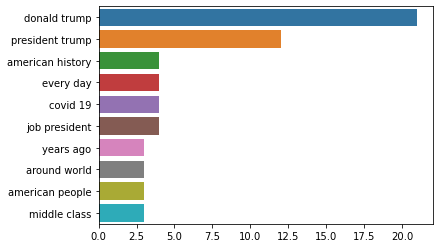

In [15]:
# top 10 bigrams - all sample data
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_10_bigrams = get_top_ngram(tweets['cleaned_tweets'],2)[:10] 
x,y = map(list,zip(*top_10_bigrams)) 
sns.barplot(x = y,y = x)

The bar chart shows the top 10 bigrams in the sample data. From this chart, we can tell Biden mentioned president Donald Trump a lot which quite makes sense as they are competitors. Following, I will explore further on Biden's tweets.

### Topic Modeling

In [16]:
# LDA model by bigrams
id2word = Dictionary(tweets['bigrams'])

# Term Document Frequency
corpus_bigrams = [id2word.doc2bow(text) for text in tweets['bigrams']]

[[(id2word[i], freq) for i, freq in doc] for doc in corpus_bigrams[:1]]

# Build LDA model
lda_model_bigrams = LdaModel(corpus=corpus_bigrams,
                   id2word=id2word,
                   num_topics=2, 
                   random_state=100,
                   update_every=1,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

coherence_model_lda_bigrams = CoherenceModel(model=lda_model_bigrams, texts=tweets['bigrams'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_bigrams.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7251205523133859


In [17]:
# display LDA model
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_bigrams, corpus_bigrams, id2word)
vis

C:\Users\mayye\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.02264  0.0       1        1  50.266906
1     -0.02264  0.0       2        1  49.733094, topic_info=              Term      Freq     Total Category  logprob  loglift
759    save people  1.000000  1.000000  Default  30.0000  30.0000
530      best wish  1.000000  1.000000  Default  29.0000  29.0000
1508     must seek  2.000000  2.000000  Default  28.0000  28.0000
539      send best  1.000000  1.000000  Default  27.0000  27.0000
61       hard work  1.000000  1.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
27       years ago  0.998797  2.070194   Topic2  -6.7015  -0.0303
119    soul nation  0.877587  1.547127   Topic2  -6.8309   0.1315
79       men women  0.871752  1.547450   Topic2  -6.8375   0.1246
570    main street  0.839320  1.548742   Topic2  -6.8754   0.0859
471   middle class  0.891245  2.074673   Topic2  -6.8154  -0.1464

[143 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
435       2  0.975873                19 20
938       2  0.976069        @drbiden send
1405      1  0.956944  abdication american
1406      1  0.956894      agreement rally
49        1  0.385812     american history
...     ...       ...                  ...
613       2  0.651809        work everyone
1424      1  0.956902           world push
27        1  0.483047            years ago
27        2  0.483047            years ago
1425      1  0.956815         years planet

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Both topics are relevant to Donald Trump, but we can still find some differences. Topic 1 seems to mention America from the perspective of a nation ('american people', 'american history' are mentioned a lot), which brings connections from culture or history. While topic 2 is more close to the perspective of the state (includes 'covid 19', 'government work'), which means characterising the country by formal institutions or policy.

### Sentiment Analysis

In [18]:
# get transformers
classifier = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
sentiment_analysis = tweets.cleaned_tweets_sa.apply(classifier)

KeyboardInterrupt: 

In [ ]:
# save sentiment analysis result
labels=[]
scores=[]
for sentiment in sentiment_analysis:
    labels.append(sentiment[0]['label'])
    scores.append(round(sentiment[0]['score'],4))
    
tweets['labels'] = labels
tweets['scores'] = scores

In [ ]:
# sentiment analysis result 
print(tweets.groupby(['labels'])['labels'].count())

neg_tweets = tweets[tweets['labels'] == 'NEG']
neu_tweets = tweets[tweets['labels'] == 'NEU']
pos_tweets = tweets[tweets['labels'] == 'POS']

In [ ]:
# top 10 bigrams - Negative
top_10_neg = get_top_ngram(neg_tweets['cleaned_tweets'],2)[:10] 
x1,y1 = map(list,zip(*top_10_neg)) 
sns.barplot(x = y1,y = x1)

In [ ]:
# top 10 bigrams - Neutral
top_10_neu = get_top_ngram(neu_tweets['cleaned_tweets'],2)[:10] 
x2,y2 = map(list,zip(*top_10_neu)) 
sns.barplot(x = y2,y = x2)

In [ ]:
# top 10 bigrams - Positive
top_10_pos = get_top_ngram(pos_tweets['cleaned_tweets'],2)[:10] 
x3,y3 = map(list,zip(*top_10_pos)) 
sns.barplot(x = y3,y = x3)

We can see 'donald trump' remains a high frequency in all the sentiments, but it is not the most frequent bigrams in positive sentiment. The tweets labelled as negative seem to describe Trump's term of office (as it shows 'supreme court' 'repeal aca'), while the positive tweets are more close to Biden himself (as it shows 'vice president'). And for the neutral tweets, public topics such as covid-19 are mentioned.

To sum up, this project presents a descriptive and exploratory analysis for detecting Biden's campaign strategies on social media. More theoretical evidence on social media and political campaigns is needed to explain the outcome.